<a href="https://colab.research.google.com/github/AnshRockstar/NYC-Taxi-Trip-Duration-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [9]:
#Install Library  use to calculate the haversine distance 

!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id=library></a>
## Import libraries

In [10]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
from haversine import haversine
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id=data></a>
## Import Dataset

In [12]:
#import the data from a csv file.
path ="/content/drive/MyDrive/NYC Taxi Trip Time Predication/NYC Taxi Data.csv"
nyc_df =  pd.read_csv(path)

<a id=explore></a>
## Data Exploration
We will explore the data and modify dataset as per the our requirment for the further analysis of the problem.

In [13]:
nyc_df.shape

(1458644, 11)

In [14]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Feature details:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
- Categorizing the features :

- Let's divide features into categories:

- Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

- Time related: pickup_datetime, dropoff_datetime

- Identifier: id(not useful for analysis)

- Others: vendor_id, passenger_count, store_and_fwd_flag


### Label details:
- trip_duration - duration of the trip in seconds 

In [15]:
# checking data-types of variables to identify the numerical and categorical variables
nyc_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them

### NAN or Missing Values:

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow

In [17]:
#Check for NaN values
nyc_df['trip_duration'].isnull().sum()

0

In [18]:
#Check for duplicated values
nyc_df.drop_duplicates(inplace=True)
nyc_df.shape

(1458644, 11)

- There are approx **1.5 million records** in our dataset.
- There is no NaN/NULL record in the dataset, So we dont have to impute any record.

In [19]:
nyc_df['passenger_count'].value_counts().reset_index()

,index,passenger_count
0,1,1033540
1,2,210318
2,5,78088
3,3,59896
4,6,48333
5,4,28404
6,0,60
7,7,3
8,9,1
9,8,1


In [20]:
nyc_df[nyc_df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [21]:
nyc_df=nyc_df[nyc_df['passenger_count']!=0]

In [22]:
#Convert timestamp to datetime format to fetch the other details as listed below
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df['dropoff_datetime'])
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



 ### Exploratory Data Analysis

[Text(0.5, 1.0, 'Distribution Plot for Trip Duration')]

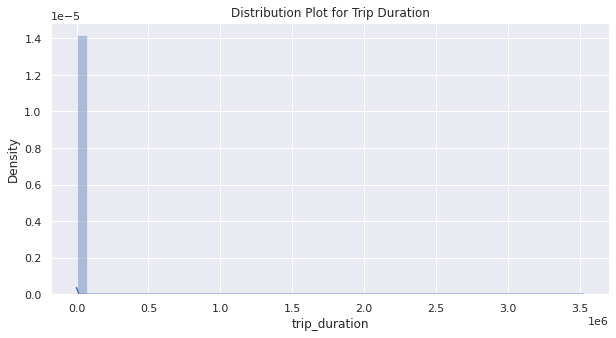

In [23]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(nyc_df['trip_duration'],color="b").set(title='Distribution Plot for Trip Duration')

[Text(0.5, 1.0, 'Distribution Plot with Log Transformation for Trip Duration')]

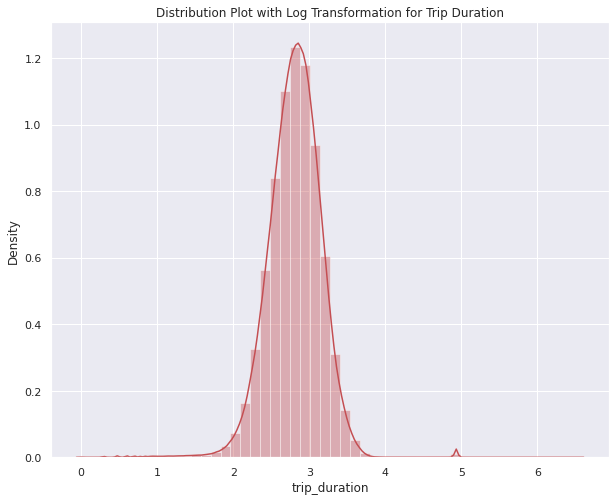

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(np.log10(nyc_df['trip_duration']),color="R").set(title='Distribution Plot with Log Transformation for Trip Duration')

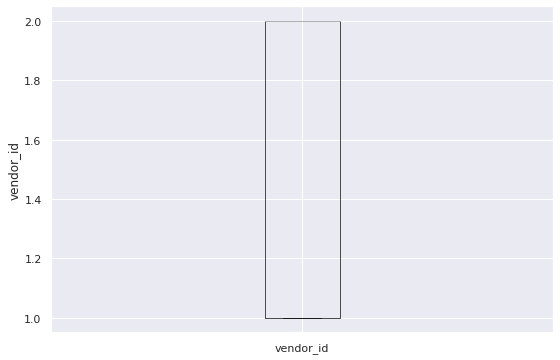

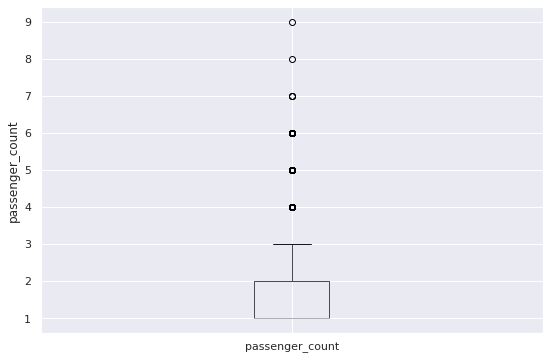

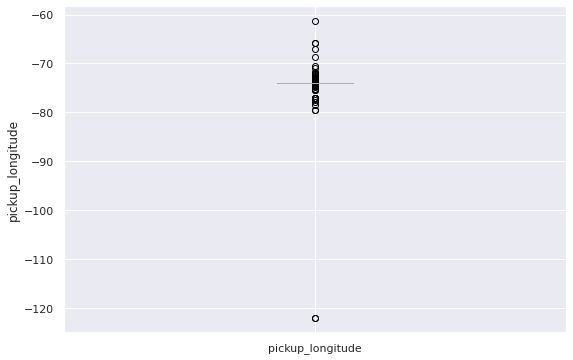

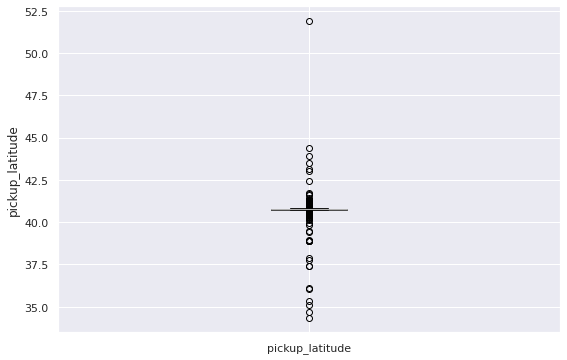

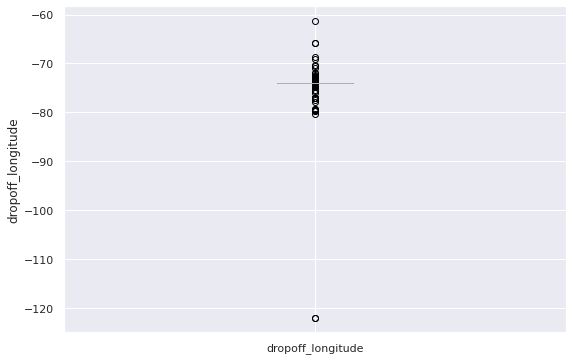

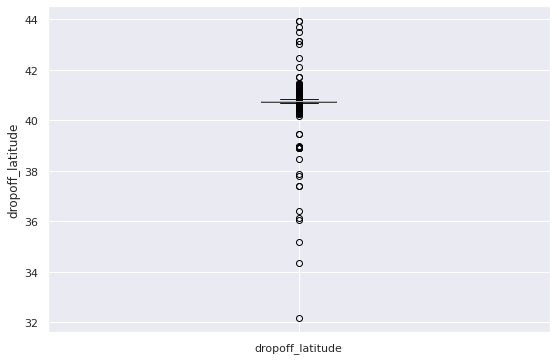

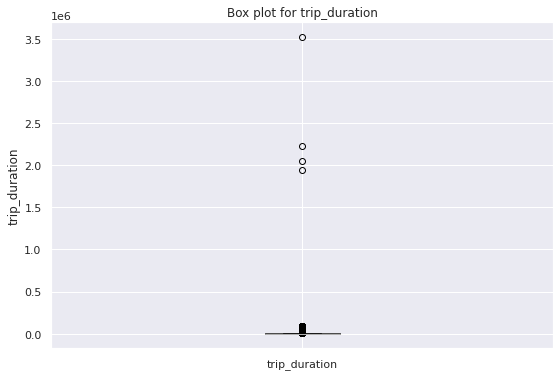

In [25]:
# plot a boxplot for the label by each numerical feature  
for col in nyc_df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  nyc_df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.title("Box plot for trip_duration")
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

Checking consitency of trip_duration

from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check the consitency of feature "trip duration". To do so we calculate the difference between pick and dropoff time.

In [26]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [27]:
# creating a feature which stores this calculated trip duration
nyc_df['calculate_trip_duration']=nyc_df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [28]:
# checking for consistency by comparing trip duration with calculated trip duration
(nyc_df['calculate_trip_duration']==nyc_df['trip_duration']).value_counts()

True    1458584
dtype: int64

Here, we see that there the trip duration is consistent with the calculated trip duration. so, this large value are purely an outlier.

In [29]:
# Dropping the feature created 
nyc_df.drop(['calculate_trip_duration'],axis=1,inplace=True)

To checked for outlier we segregate our dependent variable into different categories i.e trip whose duration is less then 1min, within 10mins,within hour,within day, within two day and more than two day

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

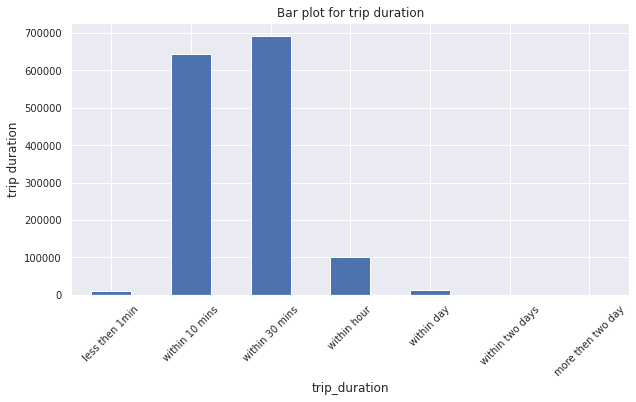

In [30]:
# segregrating the dependent variable into different categories.
plt.figure(figsize=[10,5])
labels=['less then 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more then two day']
nyc_df.groupby(pd.cut(nyc_df['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar',fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
plt.ylabel("trip duration")
plt.xticks(rotation=45)

In [31]:
numeric_features = nyc_df.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

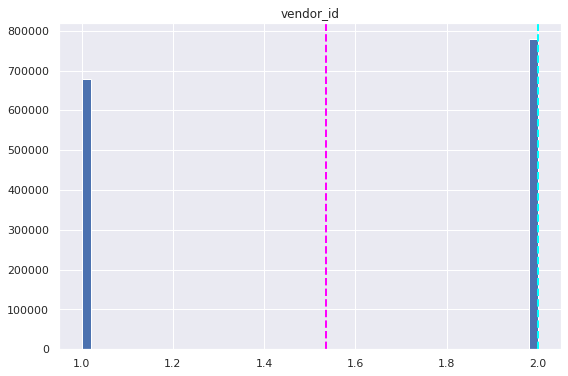

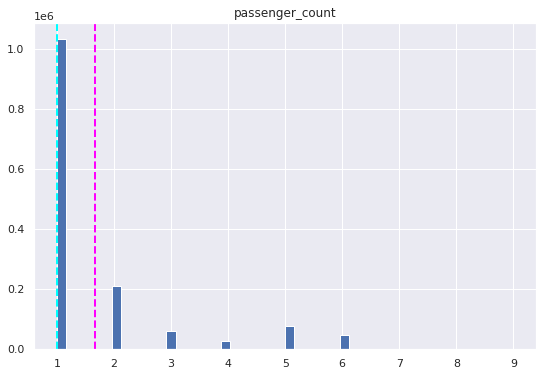

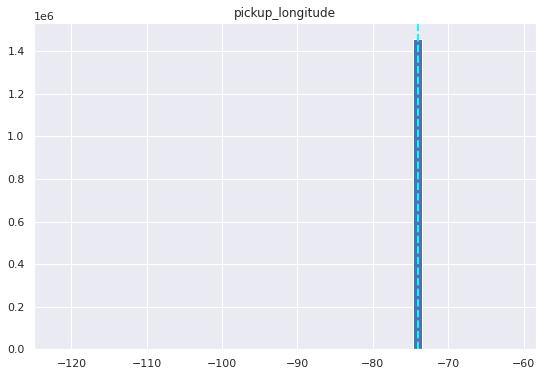

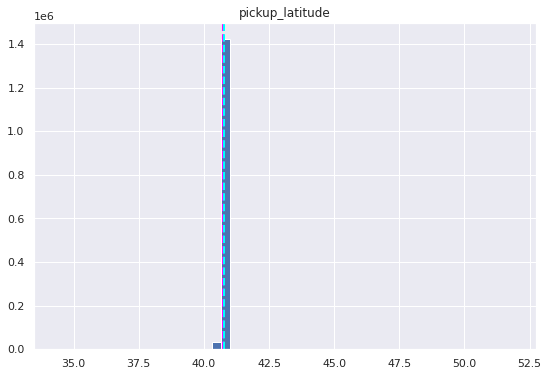

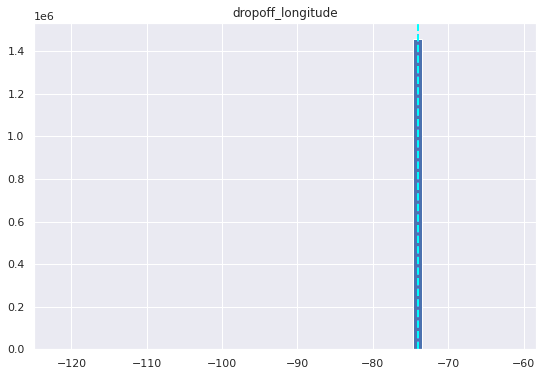

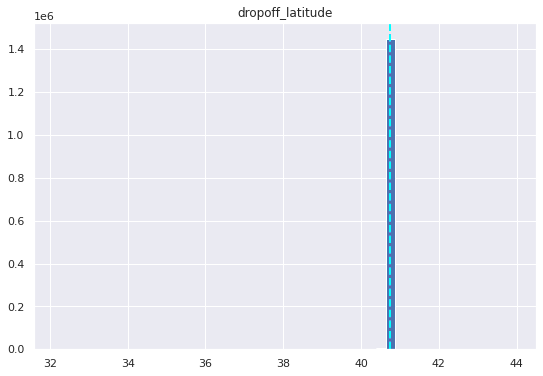

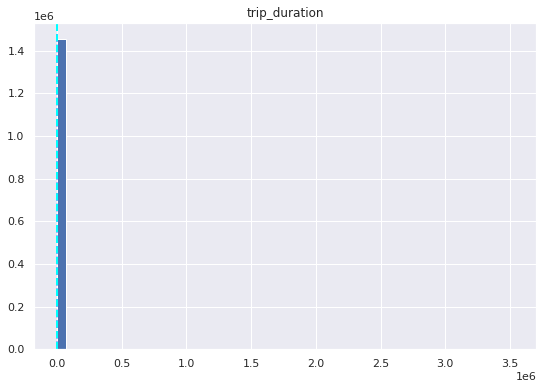

In [32]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = nyc_df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

In [33]:
nyc_df.describe().columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

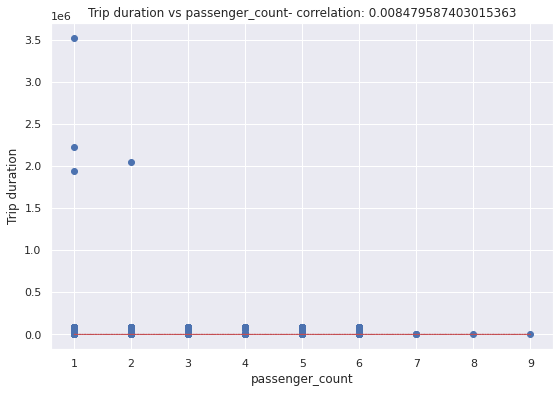

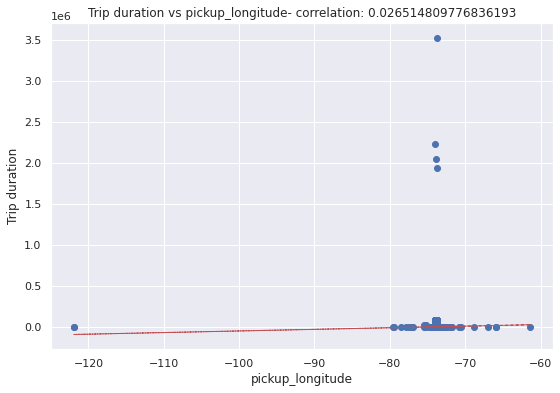

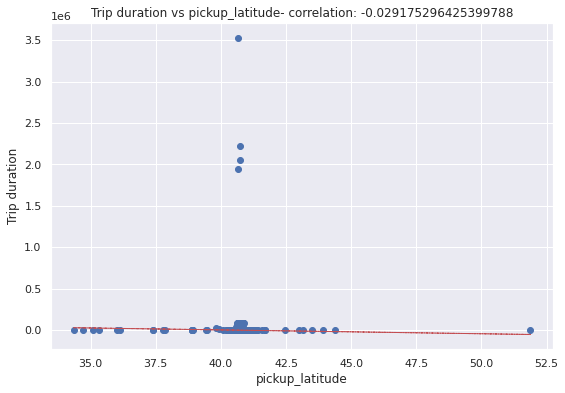

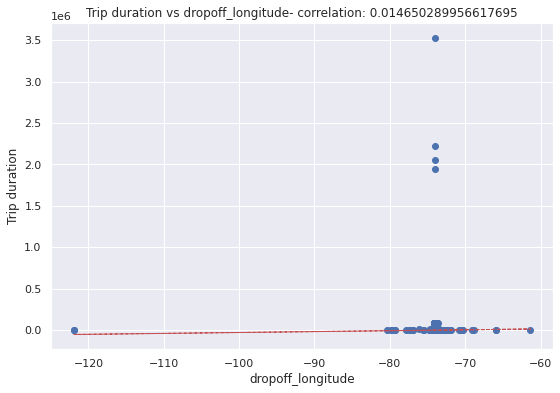

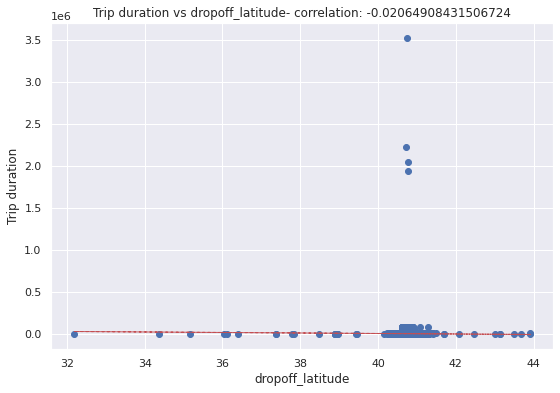

In [34]:

for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = nyc_df[col]
    label = nyc_df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(nyc_df[col], nyc_df['trip_duration'], 1)
    y_hat = np.poly1d(z)(nyc_df[col])

    plt.plot(nyc_df[col], y_hat, "r--", lw=1)

plt.show()

<a id=map></a>
# Map Visualization
***
We shall visualize the Taxi pickup locations by placing long and lat marker on the MAP of the US. So that we can analyze below questions:
 - Are all pickups constrained to NYC and it's surrounding areas?
 - Is there any unusual location of the pickup?
 - Are the lat long constrained to the land area of the US and nowhere else?

(-74.03, -73.75)

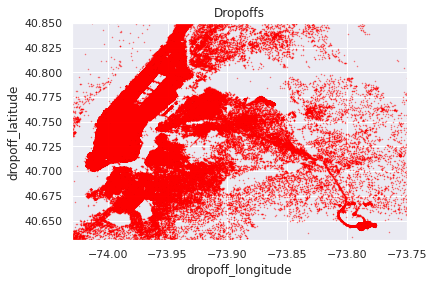

In [35]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

nyc_df.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='Red',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

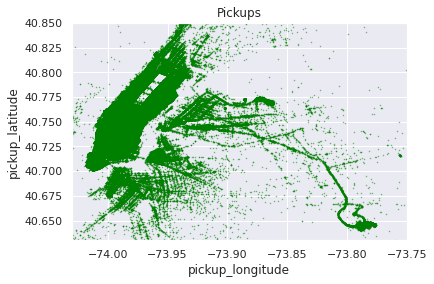

In [36]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

nyc_df.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Pickups')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [37]:
def select_within_boundingbox(df, BB):
    return ((nyc_df["pickup_longitude"] >= BB[0]) & (nyc_df["pickup_longitude"] <= BB[1]) & 
            (nyc_df["pickup_latitude"] >= BB[2]) & (nyc_df["pickup_latitude"] <= BB[3]) &
            (nyc_df["dropoff_longitude"] >= BB[0]) & (nyc_df["dropoff_longitude"] <= BB[1]) &
            (nyc_df["dropoff_latitude"] >= BB[2]) & (nyc_df["dropoff_latitude"] <= BB[3]))
BB = (-74.3, -73.0, 40.6, 41.7)

<a id=Folium></a>
## Folium
***

folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. Manipulate your data in Python, then visualize it in on a Leaflet map via folium.

Concepts
folium makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

In [38]:
import folium   

In [39]:
nyc = folium.Map(location=[40.730610,-73.935242],zoom_start=12, control_scale=True)
nyc

In [40]:
for i in nyc_df.index[:100]:
  folium.Marker(location=[nyc_df['pickup_latitude'][i],nyc_df['pickup_longitude'][i]],icon=folium.Icon(color="blue")).add_to(nyc)
nyc

In [41]:
for i in nyc_df.index[:100]:
  folium.Marker(location=[nyc_df['dropoff_latitude'][i],nyc_df['dropoff_longitude'][i]],icon=folium.Icon(color="red", icon="info-sign")).add_to(nyc)
nyc

 ### FEATURE ENGINEERING

Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy.

In [42]:
#Calculate and assign new columns to the dataframe such as pickupday,
#dropoffday which will help us to gain more insights from the data.
nyc_df['pickup_day']=nyc_df['pickup_datetime'].dt.day_name()
nyc_df['dropoff_day']=nyc_df['dropoff_datetime'].dt.day_name()
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday


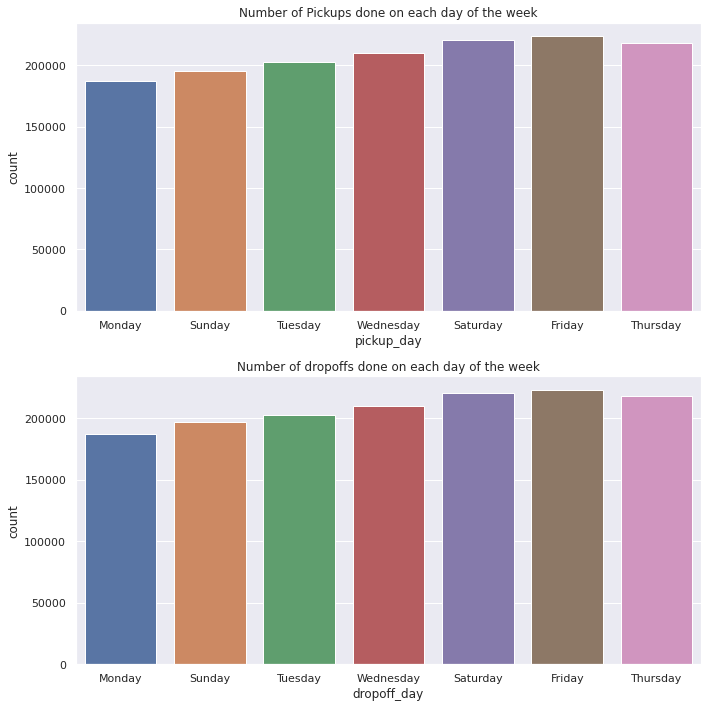

In [43]:
#Number of Pickups and Dropoff on each day of the week
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=nyc_df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=nyc_df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')

plt.tight_layout()

Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.

In [44]:
bins=np.array([0,1800,3600,5400,7200,90000])
nyc_df['duration_time']=pd.cut(nyc_df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [45]:

import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
nyc_df['pickup_timezone']=nyc_df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
nyc_df['dropoff_timezone']=nyc_df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

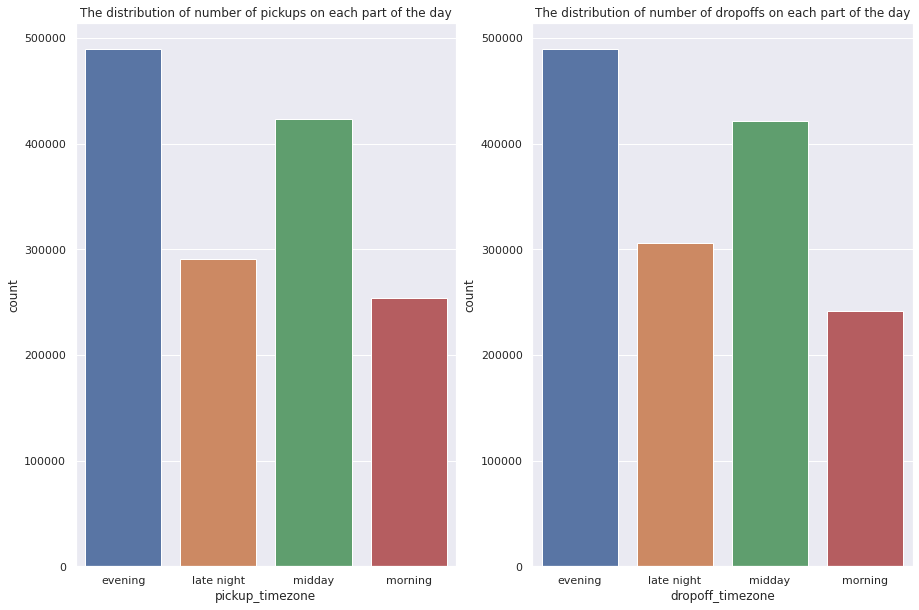

In [46]:
# Distribution of the no of Pickups and Dropoffs in a day
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=nyc_df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=nyc_df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [47]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [48]:
#Calculate distance and assign new column to the dataframe.
nyc_df["distance"] = nyc_df.apply(lambda x: calc_distance(x),axis=1)

### Outlier Detection using IQR Method


IQR=Q3-Q1

lower_limit_outlier=Q1-1.5*IQR

upper_limit_outlier=Q3+1.5*IQR¶

so we have to take the values which is greater then lower limit outlier and less then upper limit outlier
remove the outlier present in distance

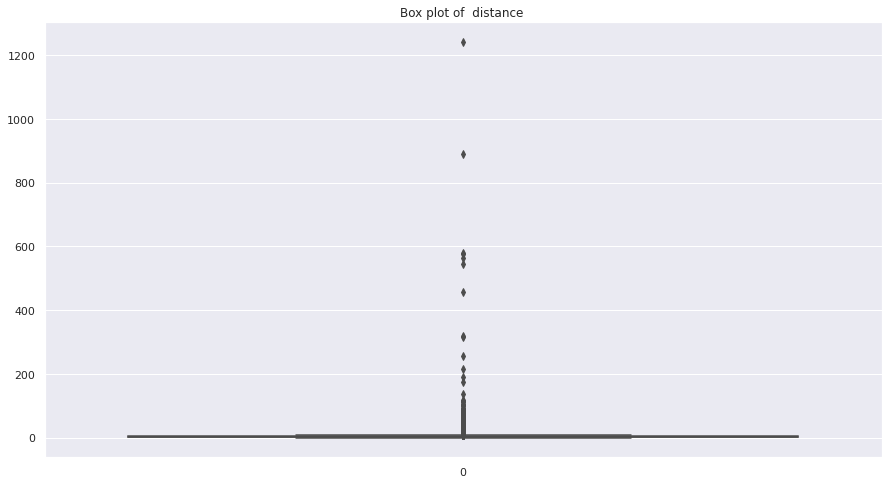

In [49]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=nyc_df['distance'], orient="v")

In [50]:
percentile_q1 = np.percentile(nyc_df['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(nyc_df['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(nyc_df['distance'],75)
print(percentile_q3)

1.2319108384989683
2.0937848447236194
3.875450446022868


In [51]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.7333985727868804
Upper limit for outlier  : 7.840759857308717


In [52]:
nyc_df=nyc_df[nyc_df['distance']>lower_limit_outlier]
nyc_df=nyc_df[nyc_df['distance']<upper_limit_outlier]

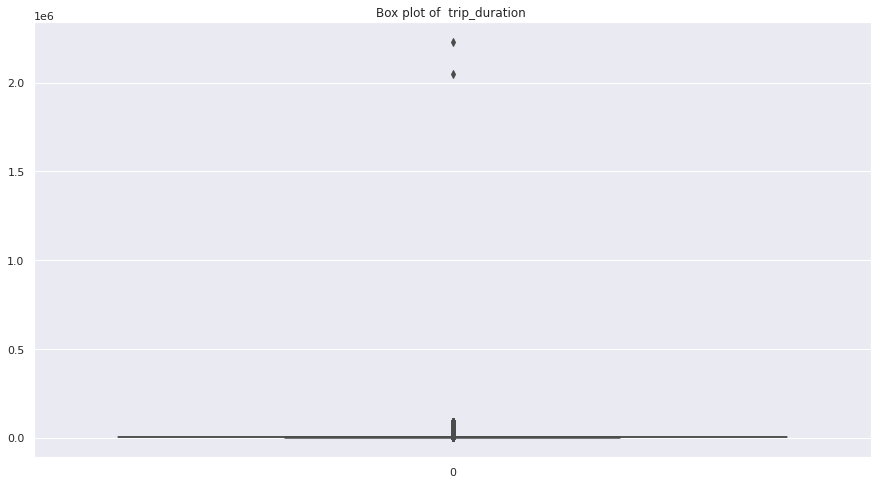

In [53]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=nyc_df['trip_duration'], orient="v")

In [54]:
percentile_q1_trip_duration = np.percentile(nyc_df['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(nyc_df['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(nyc_df['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [55]:
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [56]:
nyc_df=nyc_df[nyc_df['trip_duration']>0]
nyc_df=nyc_df[nyc_df['trip_duration']<upper_limit_outlier_trip_duration]

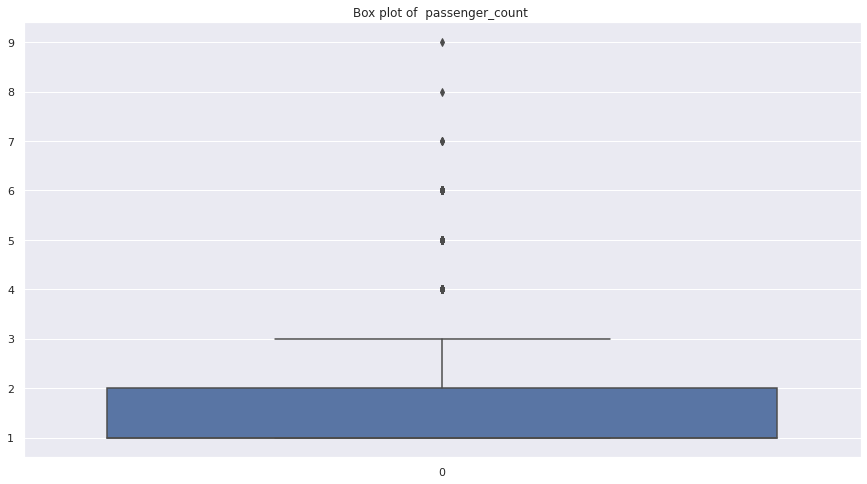

In [57]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=nyc_df['passenger_count'])

In [58]:
percentile_q1_passenger_count = np.percentile(nyc_df['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(nyc_df['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(nyc_df['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [59]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [60]:

nyc_df=nyc_df[nyc_df['passenger_count']>0]
nyc_df=nyc_df[nyc_df['passenger_count']<upper_limit_outlier_passenger_count]

In [61]:
#convert dattime in "%Y-%m-%d %H:%M:%S" format
nyc_df["pickup_datetime"] = pd.to_datetime(nyc_df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [62]:
#Calculate and assign new columns to the dataframe such as year,
#month ,day_num,hour and minute which will help us to gain more insights from the data.
nyc_df['Day']=nyc_df['pickup_datetime'].dt.day_name()

nyc_df["year"] = nyc_df["pickup_datetime"].apply(lambda x: x.year)
nyc_df["month"] = nyc_df["pickup_datetime"].apply(lambda x: x.month)
nyc_df["day_num"] = nyc_df["pickup_datetime"].apply(lambda x: x.day)
nyc_df["hour"] = nyc_df["pickup_datetime"].apply(lambda x: x.hour)
nyc_df["minute"] = nyc_df["pickup_datetime"].apply(lambda x: x.minute)

In [63]:
nyc_df['trip_duration_hour']=nyc_df['trip_duration']/3600
nyc_df['log_distance']=np.log(nyc_df.distance)
nyc_df['log_trip_duration']=np.log(nyc_df.trip_duration_hour)






Converting trip duration into hours.

Taking log of our distance for normalisation of data.

Taking log of our trip duration as well to normalize it's data too.

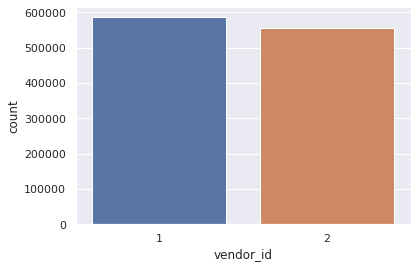

In [64]:
#Distribution of the vendor id for the taxi trip
sns.countplot(x='vendor_id',data=nyc_df)

Though both the vendors seems to have almost equal market share. But Vendor 1 is evidently more famous among the population as per the above graph.

<a id=flag></a>
## Store_and_fwd_flag
***
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

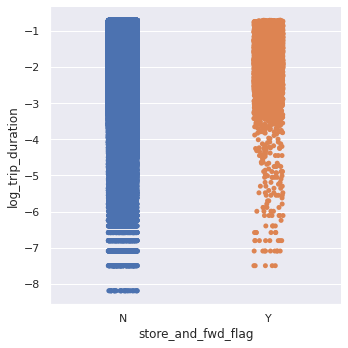

In [65]:
#Distribution of the Store and Fwd flag
sns.catplot(x="store_and_fwd_flag", y="log_trip_duration",kind="strip",data=nyc_df)

### Observations: 
- Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server. This might have occured because of the following reasons:
 1. Outstation trips didn't had proper connection at the time when trip completes.
 2. Temporary loss of signals while the trip was about to finish
 3. Inconsistent signal reception over the trip duration.
 4. The GPS or mobile device battery was down when the trip finished.

Let's check further

<a id=bivariate></a>
# Bivariate Analysis
***
Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

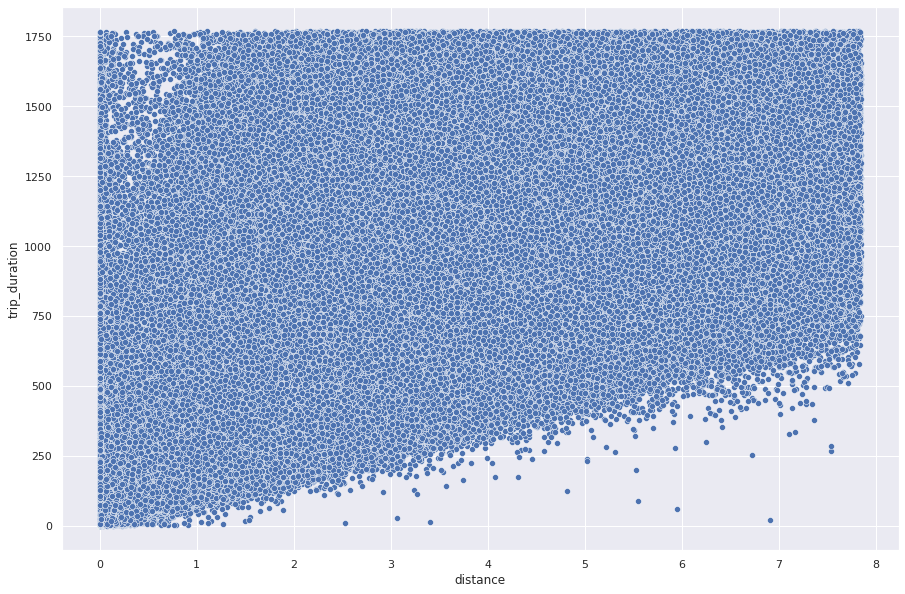

In [66]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=nyc_df)

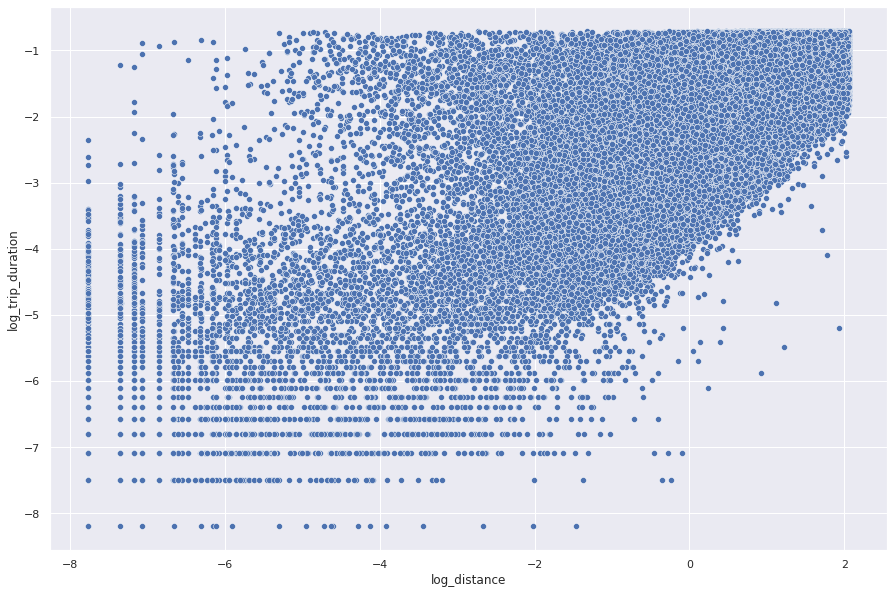

In [67]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=nyc_df)

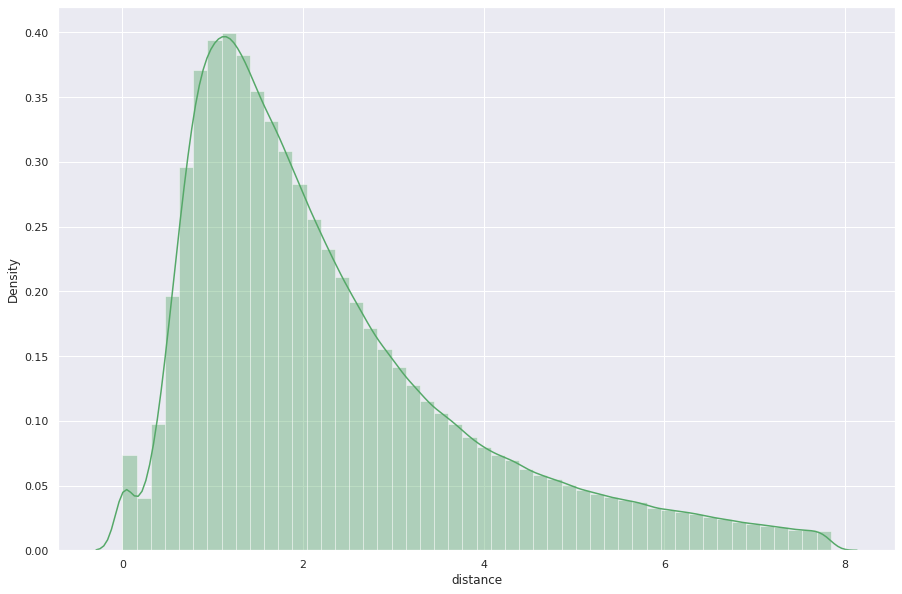

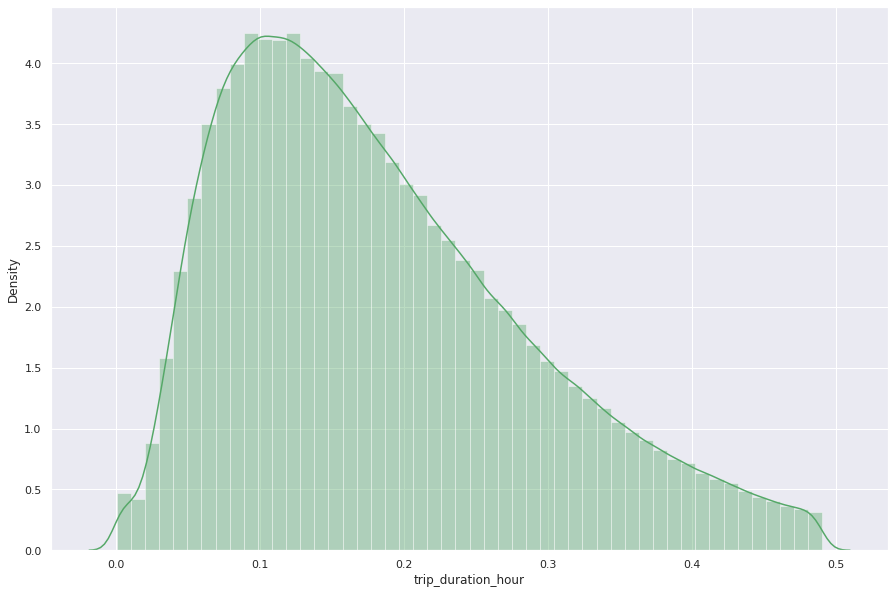

In [68]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(nyc_df[i],color="g")

In [69]:
#Dummify all the categorical features like "store_and_fwd_flag, Day" except the label i.e. "trip_duration"
nyc_df= pd.get_dummies(nyc_df, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [70]:
#Feature for the Machine learning models
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [71]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_data=nyc_df[newdata]

In [72]:
nyc_df.shape

(1142605, 33)

### Split Data

Lets split our data first before scaling the features

In [73]:
#For Standarization  apply z-score
from scipy.stats import zscore
#Train test split
X = nyc_df[features].apply(zscore)[:100000]
y=nyc_df['trip_duration_hour'][:100000]

In [74]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [76]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


<a id=corr></a>
# Correlation Analysis
***
Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.

<a id=heatmap></a>
## Heatmap
***
A heatmap is a graphical representation of data that uses a system of color-coding to represent statistical relationship between different values.

Let's plot the relationship between the features of the **Feature selection** group first


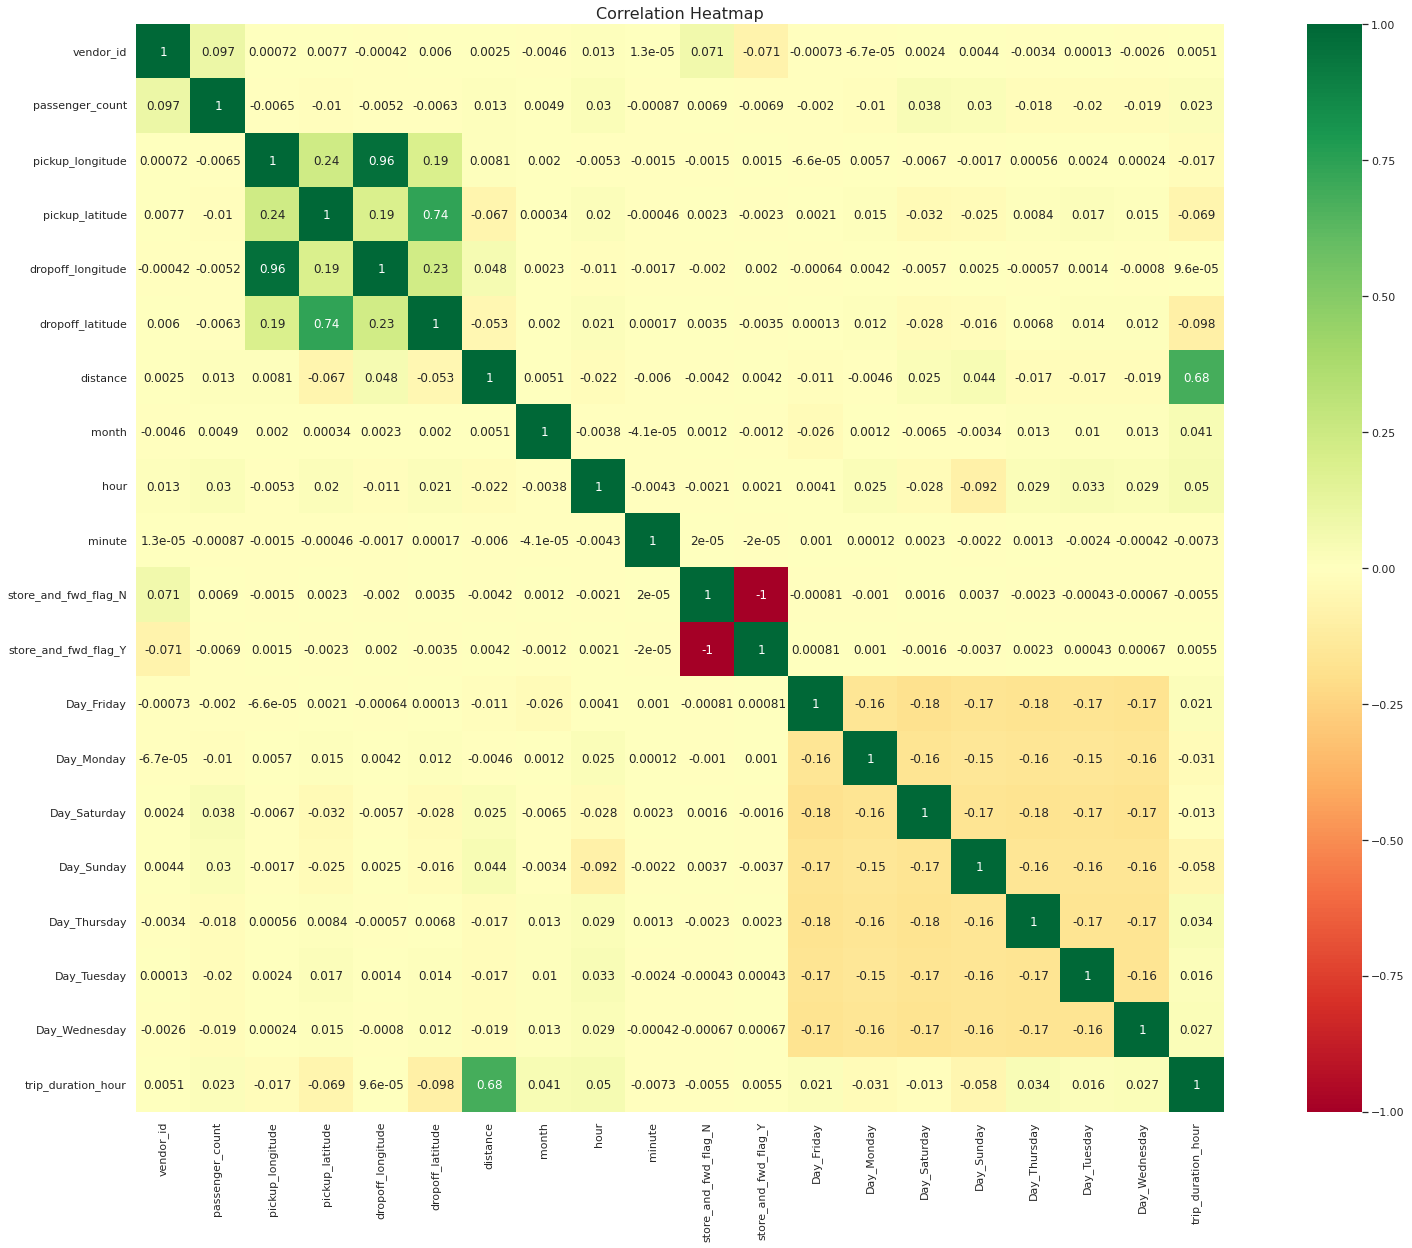

In [77]:
plt.figure (figsize= (30,20))

sns.heatmap(trip_data.corr(), cmap='RdYlGn', annot=True,vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [78]:

# Function for evaluation metric for regression
def EvaluationMetric(Xt,yt,yp,disp="on"):
  ''' Take the different set of parameter and prints evaluation metrics '''
  MSE=round(mean_squared_error(y_true=yt,y_pred=yp),4)
  RMSE=(np.sqrt(MSE))
  R2=(r2_score(y_true=yt,y_pred=yp))
  Adjusted_R2=(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
  if disp=="on":
    print("MSE :",MSE,"RMSE :", RMSE)
    print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)

  #Plotting Actual and Predicted Values
  plt.figure(figsize=(18,6))
  plt.plot((yp)[:100]) 
  plt.plot((np.array(yt)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Time Duration')


  
  return (MSE,RMSE,R2,Adjusted_R2) 


### Linear Regression

Linear regression analysis is used to predict the value of a variable based on the value of another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.

In [79]:
# Instance the linear regression object
reg = LinearRegression().fit(X_train, y_train)

In [80]:
reg.score(X_train, y_train)

0.4977612627090279

In [81]:
y_pred_train = reg.predict(X_train)

In [82]:
y_pred_test = reg.predict(X_test)

MSE : 0.0055 RMSE : 0.07416198487095663
R2 : 0.4977612627090279 Adjusted R2 : 0.49764195118103927


(0.0055, 0.07416198487095663, 0.4977612627090279, 0.49764195118103927)

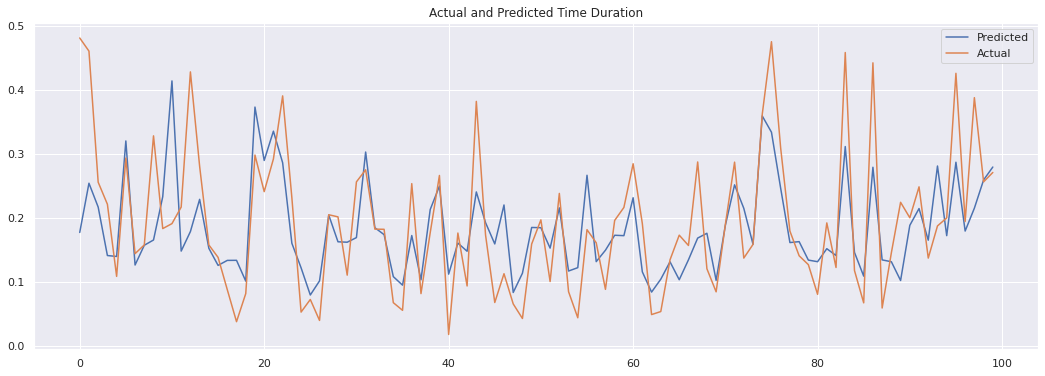

In [83]:
#Evaluation metrics for Train set
EvaluationMetric(X_train,y_train,y_pred_train)


MSE : 0.0055 RMSE : 0.07416198487095663
R2 : 0.4959360664530216 Adjusted R2 : 0.4954567263760751


(0.0055, 0.07416198487095663, 0.4959360664530216, 0.4954567263760751)

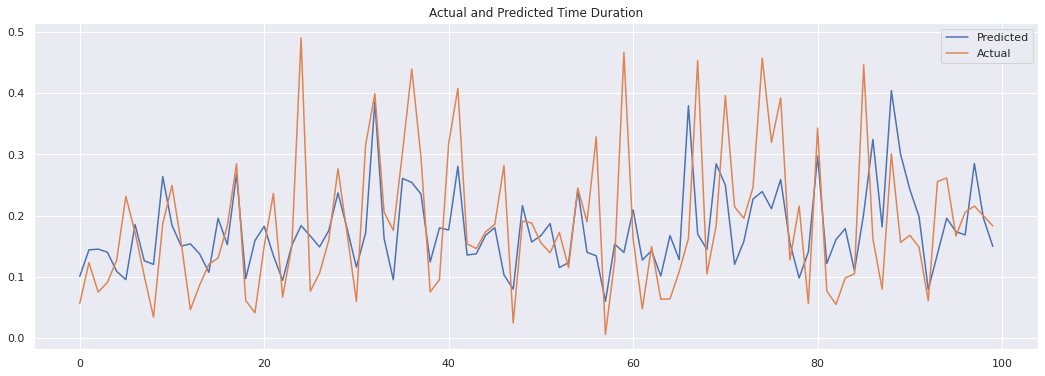

In [84]:
#Evaluation metrics for Test set
EvaluationMetric(X_test,y_test,y_pred_test)

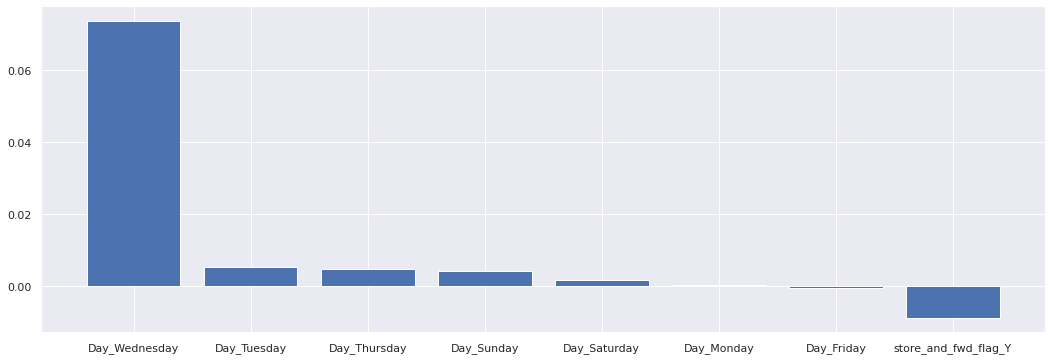

In [85]:
#Feature Importances for Linear Regression

plt.figure(figsize=(18,6))

importance=reg.coef_
importance=np.sort(importance)
feature=features
indices=np.argsort(importance)
indices=indices[:10:-1]
#plotting the features and their score in ascending order
sns.set_style("darkgrid")
plt.bar(range(len(indices)),importance[indices])
plt.xticks(range(len(indices)),[feature[i] for i in indices])
plt.show()

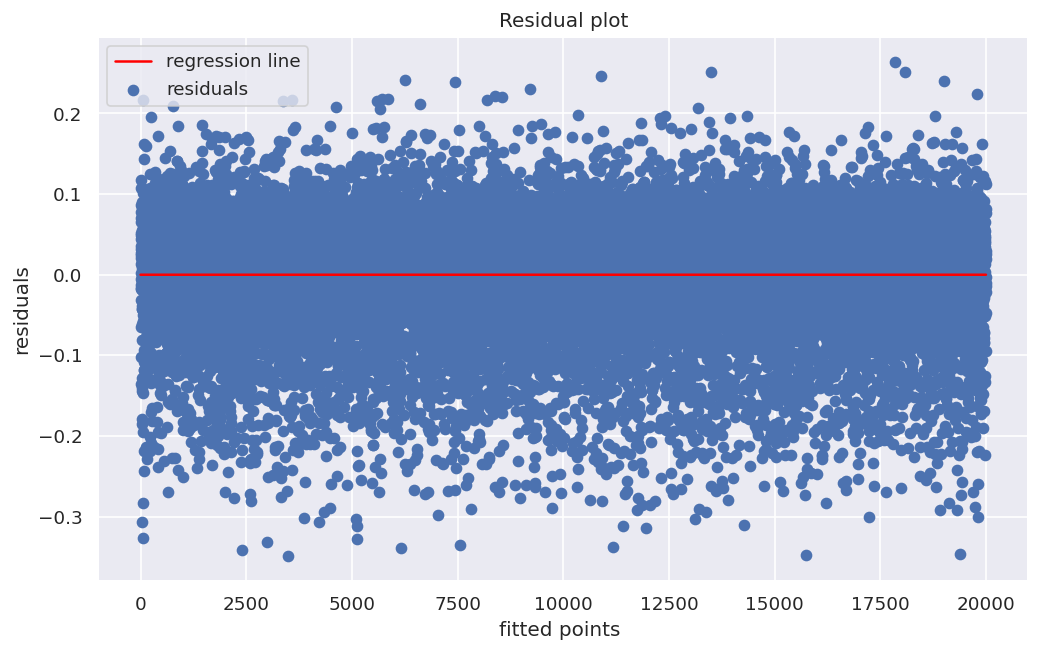

In [86]:
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()